# Algorithmic Trading Strategy Challenge

Name: _______HADEER MOTAIR______
Grade: ____________
Date: ____03/01/2004_________

In this challenge, your task is to design an algorithmic trading strategy using the stocks provided to you in the assignment.
    
You may use yfinance to source data for the stocks within the period defined in the assignment

You are not allowed to use a "buy and hold" strategy.

Your solution can be based on machine learning, technical analysis, or any other approach you find suitable.

Be creative and demonstrate your coding ability in this challenge.

In addition to implementing your strategy during this time period, you will also need to graph the profit/loss of strategy and the buy and hold over time.

Make sure to add markdown blocks and comments to expain your strategy


## Strategy Implementation

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/Users/amrmotair/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/amrmotair/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

Sharpe Ratio for Strategy: 2.92
Sharpe Ratio for Buy and Hold Strategy: -1.18


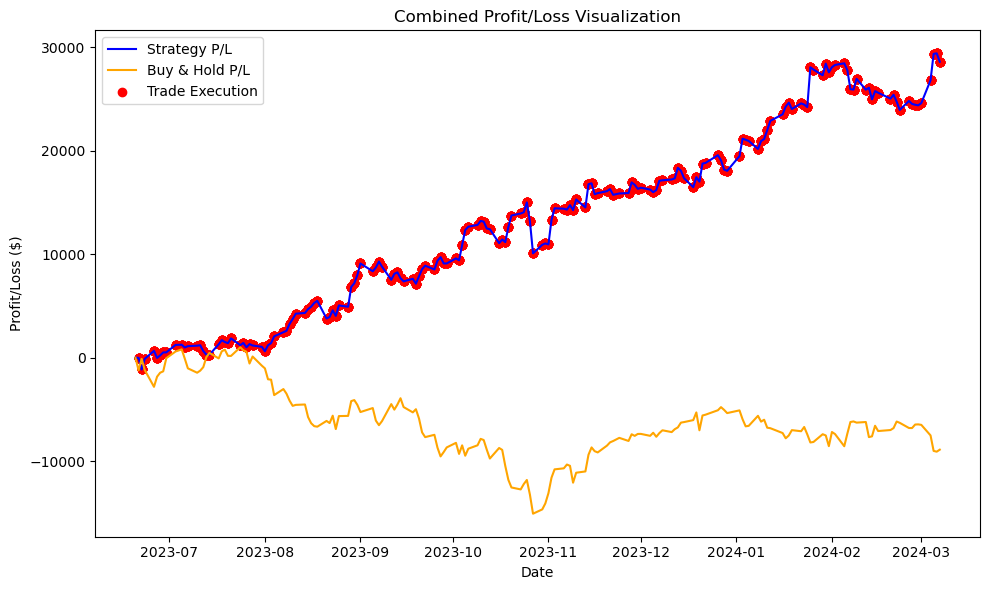

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error
# All the functions outside of the class are from github, some were adjusted.
def calculate_rsi(series, period=365):
    delta = series.diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    ma_up = up.rolling(window=period).mean()
    ma_down = down.rolling(window=period).mean()
    rsi = 100 - (100 / (1 + ma_up / ma_down))
    return rsi

def calculate_stochastic_oscillator(df, lookback_period=365):
    df['High14'] = df['High'].rolling(window=lookback_period).max()
    df['Low14'] = df['Low'].rolling(window=lookback_period).min()
    df['%K'] = 100 * ((df['Adj Close'] - df['Low14']) / (df['High14'] - df['Low14']))
    df['%D'] = df['%K'].rolling(window=3).mean()
    df['SMA20'] = df['Adj Close'].rolling(window=20).mean()
    df['RSI'] = calculate_rsi(df['Adj Close'])
    df.dropna(inplace=True)

def get_dynamic_risk_free_rate():
    def deannualize(annual_rate, periods=365):
        return (1 + annual_rate) ** (1/periods) - 1

    annualized = yf.download("^TNX", period="1d")["Adj Close"].iloc[-1]
    daily = deannualize(annualized/100)
    rate_data = pd.DataFrame({
        "annualized": [annualized],
        "daily": [daily]
    })
    return rate_data['daily'].iloc[0]

"""Github path from examples I used-
part3_neural_network_mnist_and_own_data.ipynb
Neural Networks and Deep Learning/Building your Deep Neural Network - Step by Step.ipynb
src/network2.py
https://github.com/techcentaur/Neural-Network-Python.git
"""

class MultiNNStrategy:
    def __init__(self, tickers, start_date, end_date, initial_capital):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.initial_capital = initial_capital
        self.models = {}
        self.scalers = {}
        self.data = {}
        self.signals = {}
        self.returns = {}
        self.rf_rate = get_dynamic_risk_free_rate()
        self.run_strategy()

    def download_data(self):
        """Download historical data for the specified tickers."""
        for ticker in self.tickers:
            df = yf.download(ticker, start=self.start_date, end=self.end_date)
            calculate_stochastic_oscillator(df)
            self.data[ticker] = df

    def prepare_data(self, ticker):
        """Prepare data for model training by selecting and scaling features.

        Args:
            ticker (str): The stock ticker symbol.

        Returns:
            tuple: Split training and testing data (features and targets).
        """
        df = self.data[ticker]
        features = df[['Adj Close', 'SMA20', '%K', '%D', 'RSI']].values
        targets = df['Adj Close'].shift(-1).dropna().values
        self.scalers[ticker] = StandardScaler().fit(features[:-1])
        features_scaled = self.scalers[ticker].transform(features[:-1])
        return train_test_split(features_scaled, targets, test_size=0.2, random_state=42)

    def train_model(self, ticker):
        """Train the model for each stock ticker.

        Args:
            ticker (str): The stock ticker symbol.
        """
        X_train, X_test, y_train, y_test = self.prepare_data(ticker)
        architectures = [(400, 250), (250, 50), (50, 8)] # The hidden layers were random, the input was the 5 inputs from prep_data
        #times 8 for each stock I used and I scaled it by 10.
        best_mse = float('inf')
        best_model = None
        for architecture in architectures:
            model = MLPRegressor(hidden_layer_sizes=architecture, max_iter=3000, random_state=42, alpha=0.001)
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)
            mse_test = mean_squared_error(y_test, y_pred_test)
            if mse_test < best_mse:
                best_mse = mse_test
                best_model = model
        self.models[ticker] = best_model

    def generate_signals(self):
        """Generate trading signals based on model predictions."""
        for ticker in self.tickers:
            df = self.data[ticker]
            features = df[['Adj Close', 'SMA20', '%K', '%D', 'RSI']].values
            features_scaled = self.scalers[ticker].transform(features)
            predictions = self.models[ticker].predict(features_scaled)
            df['Signal'] = 0
            df.iloc[1:, df.columns.get_loc('Signal')] = np.where(predictions[:-1] > df['Adj Close'].shift(1)[:-1], 1, -1)
            self.signals[ticker] = df['Signal']

    def execute_trades(self):
        """Execute trades based on the generated signals."""
        initial_allocation_per_ticker = self.initial_capital / len(self.tickers)
        capital_allocation = {ticker: initial_allocation_per_ticker for ticker in self.tickers}
        shares_owned = {ticker: 0 for ticker in self.tickers}

        for ticker in self.tickers:
            df = self.data[ticker]
            signals = df['Signal']

            for i, signal in enumerate(signals):
                if signal == 1 and capital_allocation[ticker] > 0:
                    shares_to_buy = capital_allocation[ticker] // df.iloc[i]['Adj Close']
                    if shares_to_buy > 0:
                        shares_owned[ticker] += shares_to_buy
                        capital_allocation[ticker] -= shares_to_buy * df.iloc[i]['Adj Close']
                elif signal == -1 and shares_owned[ticker] > 0:
                    capital_allocation[ticker] += shares_owned[ticker] * df.iloc[i]['Adj Close']
                    shares_owned[ticker] = 0

            final_value = capital_allocation[ticker] + shares_owned[ticker] * df.iloc[-1]['Adj Close']
            self.returns[ticker] = final_value - initial_allocation_per_ticker
            capital_allocation[ticker] = final_value

        self.current_capital = sum(capital_allocation.values())

    def calculate_buy_and_hold(self):
        """Calculate the performance of a buy and hold strategy.

        Returns:
            tuple: Total final value of the buy and hold portfolio, and final values by ticker.
        """
        initial_investment_per_ticker = self.initial_capital / len(self.tickers)
        final_values = {}
        for ticker in self.tickers:
            df = self.data[ticker]
            initial_shares = initial_investment_per_ticker // df['Adj Close'].iloc[0]
            final_value = initial_shares * df['Adj Close'].iloc[-1]
            final_values[ticker] = final_value

        total_final_value = sum(final_values.values())
        return total_final_value, final_values

    def evaluate_performance(self):
        """
        Evaluates the performance of the trading strategy and compares it against a buy and hold benchmark.
        This method calculates the Sharpe Ratios for both strategies to assess their risk-adjusted returns.
        Additionally, it visualizes the profit/loss of both strategies over the investment period.
        """
        dynamic_rf_rate = get_dynamic_risk_free_rate()
        portfolio_strategy_value = np.zeros(len(next(iter(self.data.values()))))
        portfolio_buy_hold_value = np.zeros(len(portfolio_strategy_value))
        initial_investment_per_ticker = self.initial_capital / len(self.tickers)

        trade_execution_dates = []

        for ticker in self.tickers:
            df = self.data[ticker].copy()
            df['Signal'] = self.signals[ticker]

            trade_execution_dates.extend(df.index[df['Signal'] != 0])

            df['Strategy'] = (df['Signal'].shift(1) * df['Adj Close'].pct_change() + 1).cumprod()
            df['Buy_Hold'] = (df['Adj Close'].pct_change() + 1).cumprod()

            portfolio_strategy_value += df['Strategy'].fillna(1) * initial_investment_per_ticker
            portfolio_buy_hold_value += df['Buy_Hold'].fillna(1) * initial_investment_per_ticker
         # Create a DataFrame with the cumulative portfolio values for both strategies over time.
        portfolio_df = pd.DataFrame({
            'Strategy_Value': portfolio_strategy_value,
            'Buy_Hold_Value': portfolio_buy_hold_value
        }, index=df.index)

        strategy_daily_returns = portfolio_df['Strategy_Value'].pct_change().dropna()
        buy_hold_daily_returns = portfolio_df['Buy_Hold_Value'].pct_change().dropna()

        strategy_sharpe_ratio = (strategy_daily_returns.mean() - dynamic_rf_rate) / strategy_daily_returns.std() * np.sqrt(252)
        buy_hold_sharpe_ratio = (buy_hold_daily_returns.mean() - dynamic_rf_rate) / buy_hold_daily_returns.std() * np.sqrt(252)

        print(f"Sharpe Ratio for Strategy: {strategy_sharpe_ratio:.2f}")
        print(f"Sharpe Ratio for Buy and Hold Strategy: {buy_hold_sharpe_ratio:.2f}")

        plt.figure(figsize=(10, 6))
        plt.plot(portfolio_df.index, portfolio_df['Strategy_Value'] - self.initial_capital, label='Strategy P/L', color='blue')
        plt.plot(portfolio_df.index, portfolio_df['Buy_Hold_Value'] - self.initial_capital, label='Buy & Hold P/L', color='orange')
        plt.scatter(trade_execution_dates, [portfolio_df['Strategy_Value'][date] - self.initial_capital for date in trade_execution_dates], color='red', marker='o', label='Trade Execution')

        plt.title('Combined Profit/Loss Visualization')
        plt.xlabel('Date')
        plt.ylabel('Profit/Loss ($)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def run_strategy(self):
        """Run the trading strategy."""
        self.download_data()
        for ticker in self.tickers:
            self.train_model(ticker)
        self.generate_signals()
        self.execute_trades()
        self.evaluate_performance()

if __name__ == '__main__':
    tickers = ['AAPL', 'MSFT', 'KO', 'F', 'PEP', 'TSLA', 'JNJ', 'PFE']
    start_date = '2022-01-01'
    end_date = '2024-12-31'
    initial_capital = 100000
    strategy = MultiNNStrategy(tickers, start_date, end_date, initial_capital)




## Plot (P/L) and (Buy and Hold)

## Compare the strategy and buy and hold's sharpe ratio